# Problem2: Optimal Bayesian Estimation

# 0- First Some Data Pre-Processing

- At this moment you should have "train_PCA.pkl" and "test_PCA.pkl" files in your working directory

In [1]:
import pickle
import numpy as np
import math


train_data=pickle.load(open( "train_PCA.pkl", "rb" ),encoding ='latin1')
test_data=pickle.load(open( "test_PCA.pkl", "rb" ),encoding ='latin1')


In [2]:
categories = ['alt.atheism',
              'talk.religion.misc',
              'comp.graphics',
              'sci.space']

num_classes = len(categories)

In [3]:
val_ratio  = 0.1 
e=math.e
L = [e**-25, e**-20, e**-15, e**-10, e**-5,0,1,2,3, e**5, e**10] # range of lambda

In [4]:
#Split Train data into Train and Validation (Ratio Train : Val = 4:1)

train_num = int(train_data['data'].shape[0]*(1.0-val_ratio)) 
val_num = -1*int(train_data['data'].shape[0]*val_ratio)

In [5]:
#Train data and Train Target
#Validation data and Validation Target


train_feature = train_data['data'][:train_num]
train_target = train_data['target'][:train_num]

val_feature = train_data['data'][val_num:]
val_target = train_data['target'][val_num:]

test_feature = test_data['data']
test_target = test_data['target']
test_num = test_data['data'].shape[0] 

In [6]:
# shape of data set
print(train_feature.shape)
print(val_feature.shape)

(1830, 1500)
(203, 1500)


# 1- Find Mean and Prior for Estimating Multivariate Normal Dist. for Classes

In [7]:
# Find the mean and prior (which is just the frequency)
mu = np.zeros([train_feature.shape[1],len(categories)], dtype=float)
Pi = np.zeros(len(categories),dtype=float)
mu = np.zeros([len(categories), train_feature.shape[1]], dtype=float)
count = [0.0,0.0,0.0,0.0]
for i in range(len(train_feature)):
    mu[train_target[i]] += train_feature[i]
    count[train_target[i]] += 1
for i in range(4):
    mu[i] = mu[i] / count[i]
    Pi[i] = count[i] / len(train_feature)
mu = mu.T
print(mu.shape)

(1500, 4)


# 2- Build Models For Several Cases

For each case consider the followings:


- First, compute the covariance matrix (name it cov)

- Build the Multivariate Normal dist. based on the computed mean and cov.

- Then build the Model

- Report the Confusion Matrix, ROC and plot the data scatter and the decision boundaries in 2D (so based on top-2 PCA features). For the Confusion matrix and ROC, use Scilearn built in functions.

 *Case 0: multivariate normals with shared spherical variances:*
 
- In this case, first compute the cov to be a diagonal matrix with the same element on diag which is the average of the feasure variances, i.e. sum(diag(cov(x)))/2*eye(2), x is the data point matrix.

In [8]:
## import scipy.stats as stats

cov = sum(np.diag(np.cov(train_feature.T)))/1500*np.eye(1500)

sigma_s = sum(np.diag(np.cov(train_feature.T)))/1500

print(np.cov(train_feature.T).shape)

(1500, 1500)


In [9]:
W = np.zeros([len(categories), train_feature.shape[1]], dtype=float)
w = np.zeros(len(categories), dtype=float)
for i in range(4):
    W[i] = mu[:,i]/sigma_s
    w[i] = mu[:,i].T.dot(mu[:,i])/(2.0*sigma_s) + np.log(Pi[i])
print(W.shape)
print(w.shape)

(4, 1500)
(4,)


In [10]:
def g0(W, X, w):
    r = np.zeros([len(X), len(categories)], dtype=float)
    pred = np.zeros(len(X), dtype=float)
    for i, vector in enumerate(X):
        for j in range(4):
            r[i,j] = W[j].T.dot(vector)+w[j]
#         print(np.argsort(r[i])[-1:])
        pred[i] = np.argsort(r[i])[-1:][0]
#     return r
    return pred
train_pred = g0(W, train_feature, w)
print(train_pred.shape)

(1830,)


In [11]:
train_acc = np.sum(train_pred ==train_target )/(1.0*train_num)
print(train_acc)
test_pred = g0(W, test_feature, w)
test_acc = np.sum(test_pred ==test_target )/(1.0*test_num)
print(test_acc)

0.966120218579
0.869918699187


In [12]:
import sklearn
from sklearn import metrics
conf_mtx = metrics.confusion_matrix(test_target,test_pred)
print(conf_mtx)

[[257   8   3  51]
 [  5 372   9   3]
 [  8  24 360   2]
 [ 52   7   4 188]]


In [13]:
from sklearn.preprocessing import label_binarize
import sklearn.preprocessing

label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(4))

fpr = dict()
tpr = dict()
roc_auc = dict()
test_vectorized = label_binarizer.transform(test_data['target']) # student code
y = label_binarizer.transform(test_pred) #student code
for i in range(4):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_vectorized[:,i],y[:,i]) # i column
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# roc = metrics.roc_curve(test_target,test_pred)
# print(roc.shape)

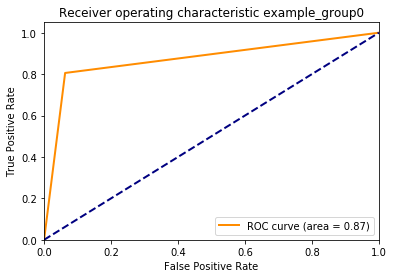

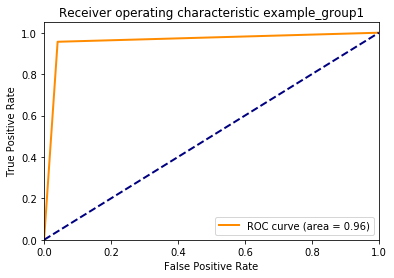

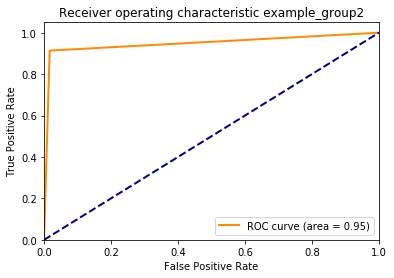

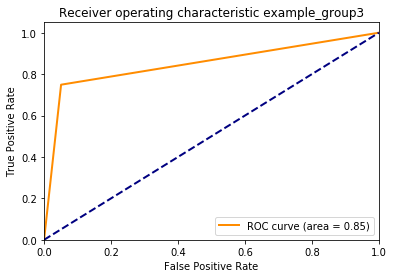

In [14]:
import matplotlib.pyplot as plt
lw = 2
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example_group'+str(i))
    plt.legend(loc="lower right")
    plt.show()
#     filename="ROC_"+str(i)+".png"
#     plt.savefig(filename)

In [49]:
#PAC-2D boundary

*Case 1: multivariate normals with shared axis parellel variances:*

- In this case, first compute the cov to be the diagonal matrix with the variance of each feasure on the diag, i.e. diag(diag(cov(x))).

In [16]:
cov = np.diag(np.diag(np.cov(train_feature.T)))
# print (cov.shape)
sigma_i = np.linalg.inv(cov)
# print(np.linalg.det(cov))
# print(np.log(np.linalg.det(cov)))

In [17]:
W = -0.5*sigma_i
w = np.zeros([len(categories), train_feature.shape[1]], dtype=float)
w0 = np.zeros(len(categories), dtype=float)
for i in range(4):
    w[i] = sigma_i.dot(mu[:,i])
    w0[i] = -0.5*mu[:,i].T.dot(sigma_i.dot(mu[:,i])) + np.log(Pi[i]) #-0.5*np.log(np.linalg.det(cov))
print(W.shape)
print(w.shape)
print(w0)

(1500, 1500)
(4, 1500)
[-3.22658928 -2.58084124 -2.6057194  -4.06961034]


In [18]:
def g1(W, w, w0, X):
    r = np.zeros([len(X), len(categories)], dtype=float)
    pred = np.zeros(len(X), dtype=float)
    for i, vector in enumerate(X):
        for j in range(4):
            r[i,j] = vector.T.dot(W.dot(vector))+w[j].T.dot(vector) + w0[j]
#         print(np.argsort(r[i])[-1:])
        pred[i] = np.argsort(r[i])[-1:][0]
#     return r
    return pred
train_pred = g1(W, w, w0, train_feature)
print(train_pred.shape)

(1830,)


In [19]:
train_acc = np.sum(train_pred ==train_target )/(1.0*train_num)
print(train_acc)
test_pred = g1(W, w, w0, test_feature)
test_acc = np.sum(test_pred ==test_target )/(1.0*test_num)
print(test_acc)
print(train_pred[0:10],train_target[0:10])
print(test_pred[0:10],test_target[0:10])

1.0
0.874353288987
[ 1.  3.  2.  0.  2.  0.  2.  1.  2.  1.] [1 3 2 0 2 0 2 1 2 1]
[ 2.  1.  1.  1.  1.  1.  2.  2.  0.  2.] [2 1 1 1 1 1 2 2 0 2]


In [20]:
import sklearn
from sklearn import metrics
conf_mtx = metrics.confusion_matrix(test_target,test_pred)
print(conf_mtx)

[[255  12  15  37]
 [  0 382   6   1]
 [  1  25 368   0]
 [ 33  23  17 178]]


In [21]:
from sklearn.preprocessing import label_binarize
import sklearn.preprocessing

label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(4))

fpr = dict()
tpr = dict()
roc_auc = dict()
test_vectorized = label_binarizer.transform(test_data['target']) # student code
y = label_binarizer.transform(test_pred) #student code
for i in range(4):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_vectorized[:,i],y[:,i]) # i column
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

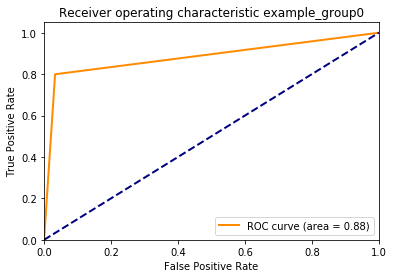

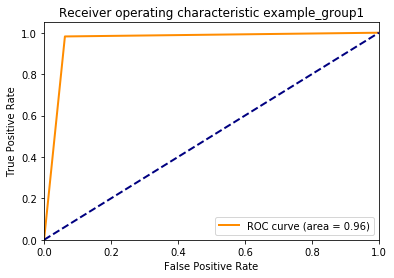

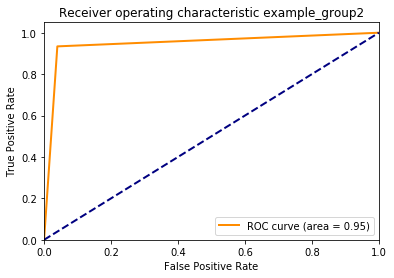

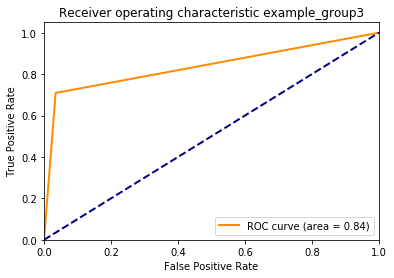

In [22]:
import matplotlib.pyplot as plt
lw = 2
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example_group'+str(i))
    plt.legend(loc="lower right")
    plt.show()
#     filename="ROC_"+str(i)+".png"
#     plt.savefig(filename)

*Case 2: multivariate normals with shared arbitrary variances:*

- In this case, first compute cov to be the general covariance matrix of feasures, i.e. cov(x).

In [23]:
cov = np.cov(train_feature.T)
sigma_i = np.linalg.inv(cov)
np.linalg.det(cov)

0.0

In [24]:
W = -0.5*sigma_i
w = np.zeros([len(categories), train_feature.shape[1]], dtype=float)
w0 = np.zeros(len(categories), dtype=float)
for i in range(4):
    w[i] = sigma_i.dot(mu[:,i])
    w0[i] = -0.5*mu[:,i].T.dot(sigma_i.dot(mu[:,i])) + np.log(Pi[i]) #-0.5*np.log(np.linalg.det(cov))
print(W.shape)
print(w.shape)
print(w0)

(1500, 1500)
(4, 1500)
[-4.03107893 -3.42079455 -3.45847431 -4.8510536 ]


In [25]:
train_pred = g1(W, w, w0, train_feature)
print(train_pred.shape)

(1830,)


In [26]:
train_acc = np.sum(train_pred ==train_target )/(1.0*train_num)
print(train_acc)
test_pred = g1(W, w, w0, test_feature)
test_acc = np.sum(test_pred ==test_target )/(1.0*test_num)
print(test_acc)
print(train_pred[0:10],train_target[0:10])
print(test_pred[0:10],test_target[0:10])

1.0
0.874353288987
[ 1.  3.  2.  0.  2.  0.  2.  1.  2.  1.] [1 3 2 0 2 0 2 1 2 1]
[ 2.  1.  1.  1.  1.  1.  2.  2.  0.  2.] [2 1 1 1 1 1 2 2 0 2]


In [27]:
import sklearn
from sklearn import metrics
conf_mtx = metrics.confusion_matrix(test_target,test_pred)
print(conf_mtx)

[[254  17  10  38]
 [  1 378   9   1]
 [  4  25 365   0]
 [ 32  20  13 186]]


In [28]:
from sklearn.preprocessing import label_binarize
import sklearn.preprocessing

label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(4))

fpr = dict()
tpr = dict()
roc_auc = dict()
test_vectorized = label_binarizer.transform(test_data['target']) # student code
y = label_binarizer.transform(test_pred) #student code
for i in range(4):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_vectorized[:,i],y[:,i]) # i column
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

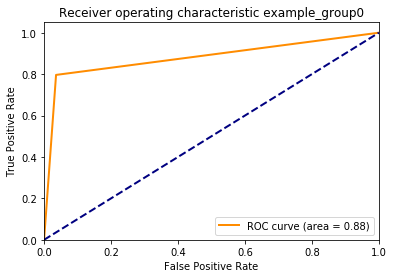

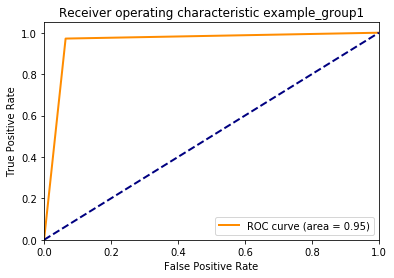

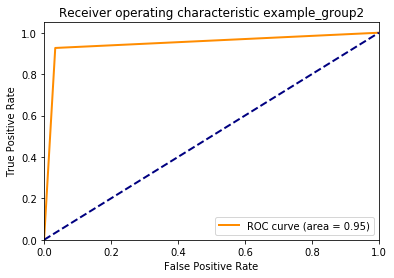

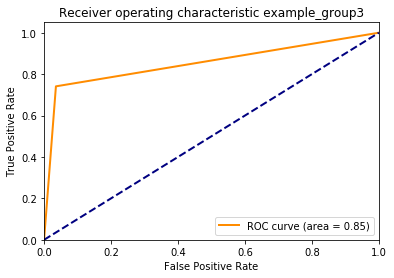

In [29]:
import matplotlib.pyplot as plt
lw = 2
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example_group'+str(i))
    plt.legend(loc="lower right")
    plt.show()
#     filename="ROC_"+str(i)+".png"
#     plt.savefig(filename)

*Case 3: multivariate normals spherical variances:*

- In this case, first compute a cov for each class.

In [30]:
# cov = np.zeros([train_feature.shape[1],train_feature.shape[1],len(categories)])

sigma_s = np.zeros(4, dtype = float)

print(cov.shape)
data_by_class = [[] for i in range(4)]

for i, vector in enumerate(train_feature):
    label = train_data['target'][i]
    data_by_class[label].append(vector)
for i in range (4):
    data_by_class[i] = np.array(data_by_class[i])
    sigma_s[i] = sum(np.diag(np.cov(data_by_class[i].T)))/1500
print(sigma_s)


(1500, 1500)
[ 0.00059963  0.00061988  0.00060377  0.00061112]


In [31]:
W = np.zeros([len(categories), train_feature.shape[1]], dtype=float)
w = np.zeros(len(categories), dtype=float)
for i in range(4):
    W[i] = mu[:,i]/sigma_s[i]
    w[i] = mu[:,i].T.dot(mu[:,i])/(2.0*sigma_s[i]) + np.log(Pi[i])
print(W.shape)
print(w.shape)

(4, 1500)
(4,)


In [32]:
train_pred = g0(W, train_feature, w)
print(train_pred.shape)

(1830,)


In [33]:
train_acc = np.sum(train_pred ==train_target )/(1.0*train_num)
print(train_acc)
test_pred = g0(W, test_feature, w)
test_acc = np.sum(test_pred ==test_target )/(1.0*test_num)
print(test_acc)

0.966120218579
0.870657797487


In [34]:
import sklearn
from sklearn import metrics
conf_mtx = metrics.confusion_matrix(test_target,test_pred)
print(conf_mtx)

[[260   7   3  49]
 [  5 371  10   3]
 [  8  23 361   2]
 [ 54   7   4 186]]


In [35]:
from sklearn.preprocessing import label_binarize
import sklearn.preprocessing

label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(4))

fpr = dict()
tpr = dict()
roc_auc = dict()
test_vectorized = label_binarizer.transform(test_data['target']) # student code
y = label_binarizer.transform(test_pred) #student code
for i in range(4):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_vectorized[:,i],y[:,i]) # i column
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

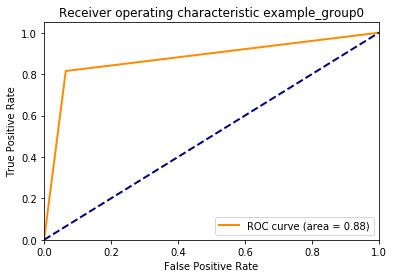

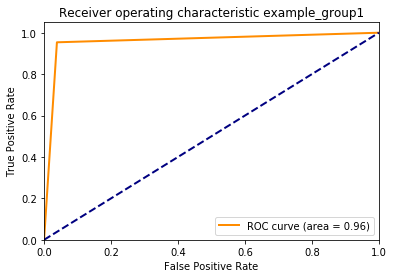

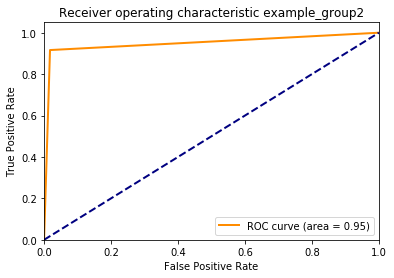

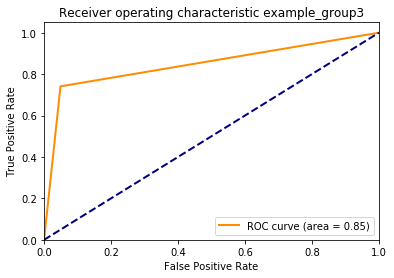

In [36]:
import matplotlib.pyplot as plt
lw = 2
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example_group'+str(i))
    plt.legend(loc="lower right")
    plt.show()
#     filename="ROC_"+str(i)+".png"
#     plt.savefig(filename)

Case 4: Same as case 3, but with reject option. Threshold 0.3

In [37]:
# cov = np.zeros([train_feature.shape[1],train_feature.shape[1],len(categories)])

sigma_s = np.zeros(4, dtype = float)

print(cov.shape)
data_by_class = [[] for i in range(4)]

for i, vector in enumerate(train_feature):
    label = train_data['target'][i]
    data_by_class[label].append(vector)
for i in range (4):
    data_by_class[i] = np.array(data_by_class[i])
    sigma_s[i] = sum(np.diag(np.cov(data_by_class[i].T)))/1500
print(sigma_s)

(1500, 1500)
[ 0.00059963  0.00061988  0.00060377  0.00061112]


In [38]:
W = np.zeros([len(categories), train_feature.shape[1]], dtype=float)
w = np.zeros(len(categories), dtype=float)
for i in range(4):
    W[i] = mu[:,i]/sigma_s[i]
    w[i] = mu[:,i].T.dot(mu[:,i])/(2.0*sigma_s[i]) + np.log(Pi[i])
print(W.shape)
print(w.shape)

(4, 1500)
(4,)


In [41]:
def g4(W, X, w):
    r = np.zeros([len(X), len(categories)], dtype=float)
    pred = np.zeros(len(X), dtype=float)
    for i, vector in enumerate(X):
        for j in range(4):
            r[i,j] = W[j].T.dot(vector)+w[j]
#         print(np.argsort(r[i])[-1:])
        index = np.argsort(r[i])[-1:][0]
        pred[i] = index
        if r[i,index]<0.7:
            pred[i] = 4
#     return r
    return pred
train_pred = g4(W, train_feature, w)
print(train_pred.shape)

(1830,)


In [44]:
count = 0
right = 0
for i, vector in enumerate(train_target):
    if train_pred[i]==4:
        continue
    count+=1
    if train_pred[i]==train_target[i]:
        right+=1
train_acc = 1.0*right/count
print(train_acc)
test_pred = g4(W, test_feature, w)
count = 0
right = 0
for i, vector in enumerate(test_target):
    if test_pred[i]==4:
        continue
    count+=1
    if test_pred[i]==test_target[i]:
        right+=1
test_acc = 1.0*right/count
print(test_acc)

0.966120218579235
0.8706577974870657


In [45]:
import sklearn
from sklearn import metrics
conf_mtx = metrics.confusion_matrix(test_target,test_pred)
print(conf_mtx)

[[260   7   3  49]
 [  5 371  10   3]
 [  8  23 361   2]
 [ 54   7   4 186]]


In [46]:
from sklearn.preprocessing import label_binarize
import sklearn.preprocessing

label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(4))

fpr = dict()
tpr = dict()
roc_auc = dict()
test_vectorized = label_binarizer.transform(test_data['target']) # student code
y = label_binarizer.transform(test_pred) #student code
for i in range(4):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_vectorized[:,i],y[:,i]) # i column
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

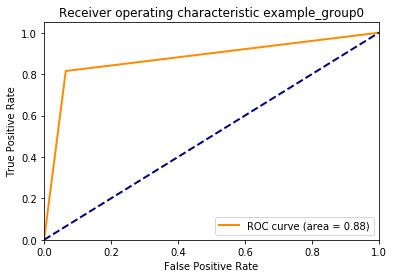

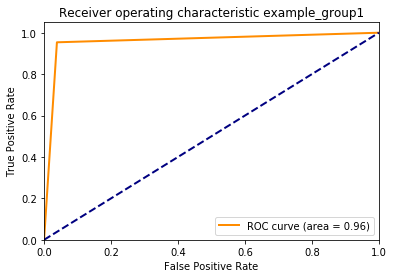

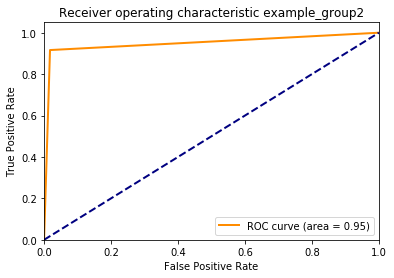

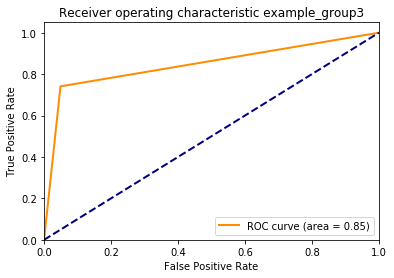

In [47]:
import matplotlib.pyplot as plt
lw = 2
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example_group'+str(i))
    plt.legend(loc="lower right")
    plt.show()